In [1]:
from qiskit import *
from qiskit.providers.ibmq import least_busy
from qiskit import Aer
from qiskit.compiler import assemble
from qiskit.visualization import plot_histogram
from qiskit.extensions import *

import numpy as np
import random

# Classical Quantum Algorithms
This notebook serves for trying out some simple quantum algorithms, that I have learned about taking the [OpenHPI Quantum Computing series](https://open.hpi.de/channels/quantum), using Python and [Qiskit (IBM)](https://en.wikipedia.org/wiki/Qiskit). Those are common quantum algorithmns, that I'm only replicating for my own reference.

## 1. True coincidence generator with one Hadamard gate 

In [2]:
# defining a circuit of 1 qubit and 1 bit

qreg = QuantumRegister(1, 'q')
creg = ClassicalRegister(1, 'c')
circuit = QuantumCircuit(qreg, creg)

In [3]:
# applying the hadamard gate to qubit and measuring

circuit.h(qreg[0])

circuit.measure(qreg[0], creg[0])

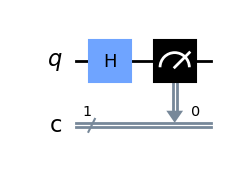

In [4]:
# visualisation of the circuit

circuit.draw('mpl')

In [5]:
# Qasm Simulator

backend = Aer.get_backend('qasm_simulator')
qobj = assemble(circuit)
result_sim = backend.run(qobj, shots=1).result()
counts = result_sim.get_counts(circuit)
print(counts)

{'1': 1}


ibmqfactory.load_account:WARNING:2022-12-18 23:36:57,414: Credentials are already in use. The existing account in the session will be replaced.


least busy backend:  ibmq_belem
Job Status: job has successfully run


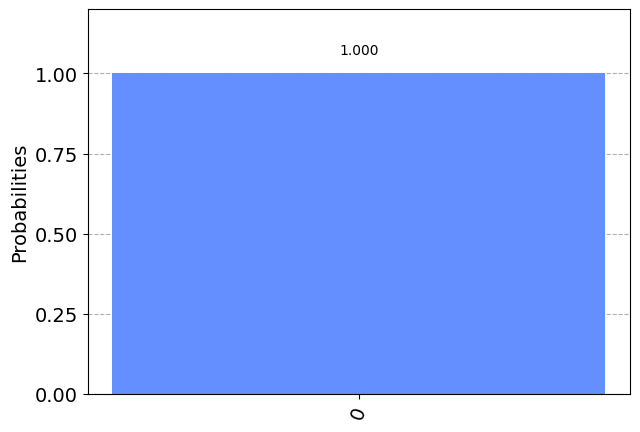

In [7]:
# Real Quantum Computer

shots = 1

IBMQ.load_account()

provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 2
and not x.configuration().simulator
and x.status().operational==True))
print("least busy backend: ", backend)

job = execute(circuit, backend=backend, shots=shots)

from qiskit.tools.monitor import job_monitor
job_monitor(job)

result = job.result()
plot_histogram(result.get_counts(circuit))

The randomly generated number is 0.

## 2. [Teleportation Algorithm](https://en.wikipedia.org/wiki/Quantum_teleportation)
Given a classical communication canal, quantum technology can (possibly savely) transfer information in real time, using two engangled (CNOT gate) qubits.

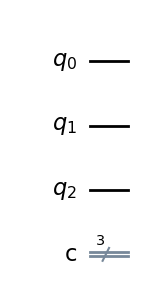

In [11]:
# defining a circuit of 3 qubits and 3 classical bits

qreg = QuantumRegister(3, 'q')
creg = ClassicalRegister(3, 'c')
circuit = QuantumCircuit(qreg, creg)

# q0: qubit of the sender before transmission
# q1: entangled qubit of the sender
# q2: entangled qubit of the receiver

circuit.draw(output='mpl')

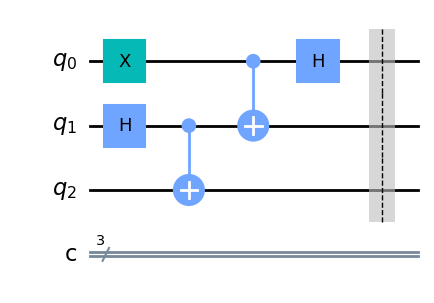

In [12]:
# building the circuit

# creating a bell state from the qubit of the sender and the receiver
circuit.h(1) # Hadamard gate
circuit.cx(1,2) # CNOT gate

# chosing one of those three possibilities:
# a) sender wants to transmit a |0>:
# no action
# b) the sender wants to transmit a |1>:
circuit.x(0)
# c) The sender wants to transmit a uniform superposition:
#circuit.h(0)

# entangeling this qubit with qubit 1 of the sender and apply Hadamard to it:
circuit.cx(0,1)
circuit.h(0)

circuit.barrier(range(3))
circuit.draw(output='mpl')

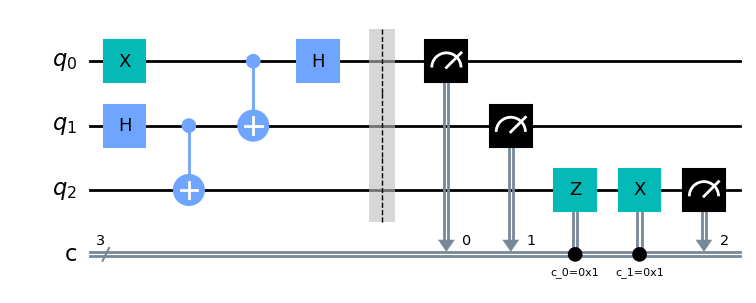

In [13]:
# measuring and saving the results as classical bits

# sender measures their two qubits
circuit.measure(0, 0)
circuit.measure(1, 1)

# depending on these measurements, the receiver applies a Z or X gate to their qubit and measures it:
circuit.z(2).c_if(creg[0], 1)
circuit.x(2).c_if(creg[1], 1)

circuit.measure(2, 2)

# display circuit
circuit.draw(output='mpl')

{'100': 262, '111': 258, '110': 247, '101': 257}


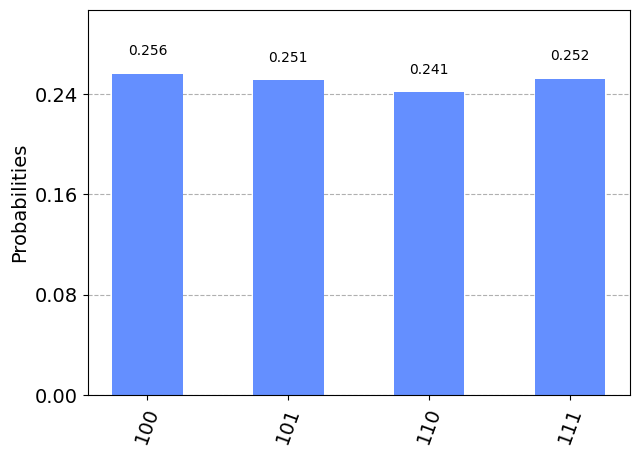

In [14]:
# run the experiment on the Quasm simulator with 1024 shots

backend = Aer.get_backend('qasm_simulator')
qobj = assemble(circuit)

result_sim = backend.run(qobj, shots=1024).result()

# show the results
counts = result_sim.get_counts(circuit)
print(counts)
plot_histogram(counts)

# the leftmost bit is the result of measuring q2 in qiskit notation
# since it's 1 in all of the expected measures, the receiver can deduce, that the sender intended to send a 1

## 3. Dense Coding
Compression of two classical bits into one qubit.

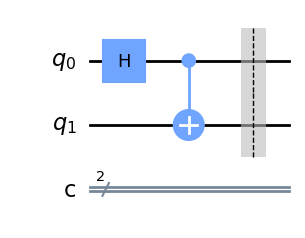

In [8]:
# defining a circuit of 2 qubits and 2 classical bits

qreg = QuantumRegister(2,'q')
creg = ClassicalRegister(2,'c')
circuit = QuantumCircuit(qreg, creg)

# creating a bell state from the two qubits:
circuit.h(0)
circuit.cx(0,1)

# q_0 stays at the sender
# q_1 goes to the receiver of the message

circuit.barrier()
circuit.draw(output = "mpl")

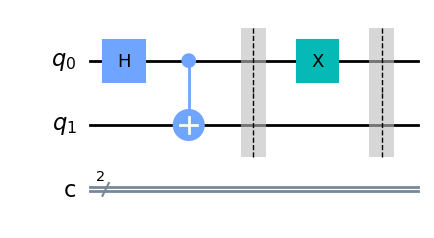

In [9]:
# coding of the message 00, 10, 01 or 11

# we want to transfer that 2-bit message using only one qubit
# depending on the message, different gates are applied to qubit 0

def codiere(qc, qubit, msg):
    if msg == "00":
      pass # do nothing ... 
    elif msg == "10":      
        qc.x(qubit) # apply an X gate   
    elif msg == "01":      
        qc.z(qubit) # apply a Z gate
    elif msg == "11":
        qc.y(qubit) # apply a Y gate
    else:     
        print("Invalid message !! 00 is being sent ....")

#message = input("Please enter one of the following messages: \n 1. 00 \n 2. 01 \n3. 10 \n4. 11 \n")
message = '10'

codiere(circuit, 0, message)

circuit.barrier()
circuit.draw(output = "mpl")

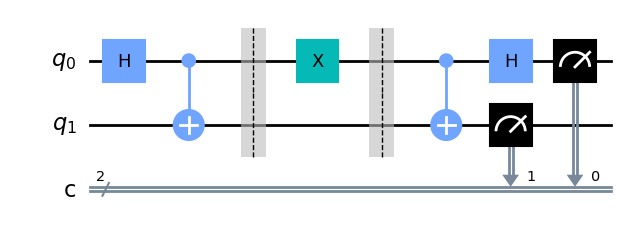

In [10]:
# after the receiver has received q0 from the sender, they can perform decoding

# same transformations, but backwards
circuit.cx(0,1)
circuit.h(0)

# measuring and saving results on classical bits
circuit.measure(qreg[0], creg[0])
circuit.measure(qreg[1], creg[1])

circuit.draw(output = "mpl")

{'10': 1024}


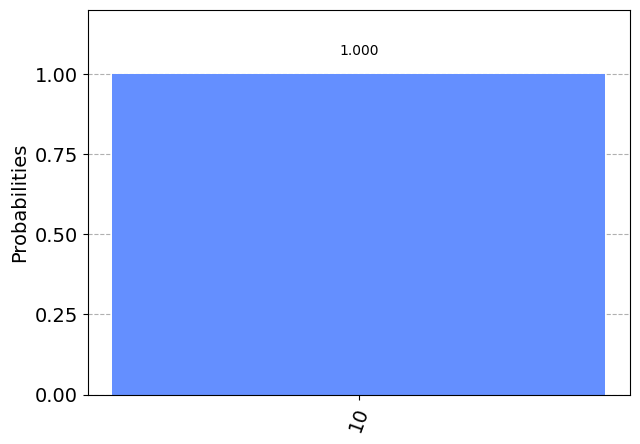

In [11]:
# running experiment on the Quasm simulator with 1024 shots

backend = Aer.get_backend('qasm_simulator')
qobj = assemble(circuit)

result_sim = backend.run(qobj, shots=1024).result()

# show results
counts = result_sim.get_counts(circuit)
print(counts)
plot_histogram(counts)

message = '10' was intended to be sent, '10' would be indeed be simulised to be recieved

least busy backend:  ibmq_lima
Job Status: job has successfully run


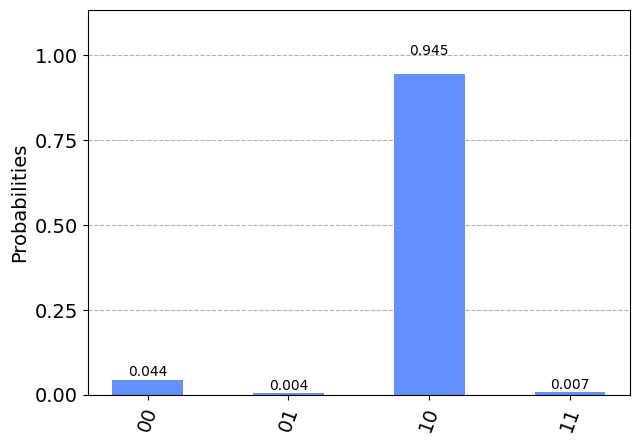

In [12]:
# using a real quantum device
shots = 4096

# loading account information
IBMQ.load_account()

provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 2
and not x.configuration().simulator
and x.status().operational==True))
print("least busy backend: ", backend)

job = execute(circuit, backend=backend, shots=shots)

from qiskit.tools.monitor import job_monitor
job_monitor(job)

result = job.result()
plot_histogram(result.get_counts(circuit))

On a real quantum device, we can see there are some errors, but statistically, we'll get to correct result.

## 4. [Deutsch Algorithm](https://en.wikipedia.org/wiki/Deutsch%E2%80%93Jozsa_algorithm)
Determining, wether a function f : { 0 , 1 } → { 0 , 1 } is constant or balanced.

In [2]:
# making up the so called oracle function, that makes f either constant or balanced

# rolling a random combination: 
# [0,0], [1,1] : constant 
# [0,1], [1,0] : balanced

secret = [random.randint(0, 1) for _ in range(2)]
print(secret)

[0, 1]


So, we got a balanced function f here.

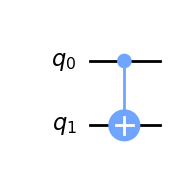

In [3]:
# constructing one of the four possible oracles with the secret

def append_oracle(circuit, secret):
    if secret[0]:
        circuit.cx(0, 1)
        circuit.x(1)
    if secret[1]:
        circuit.cx(0, 1)
    return circuit

qreg_q = QuantumRegister(2,'q')
c_reg_c= QuantumRegister(1,'c')

circ = QuantumCircuit(qreg_q)

circ=append_oracle(circ,secret)
circ.draw('mpl')

From now on, we don't care about the oracle function anymore, it can be anything. The only thing we're interested in is, wether we can determine what it does.

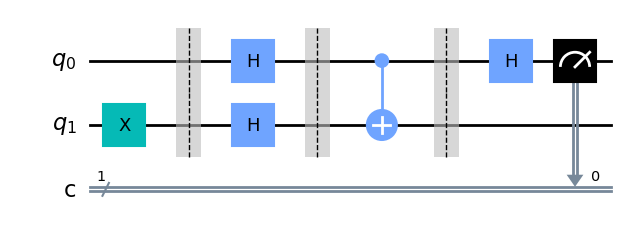

In [4]:
# making the circuit for the Deutsch algorithm

circuit = QuantumCircuit(2,1)

circuit.x(1)
circuit.barrier()
circuit.h(0)
circuit.h(1)
circuit.barrier()
append_oracle(circuit, secret)
circuit.barrier()
circuit.h(0)
circuit.measure(0, 0)

circuit.draw('mpl')

print: 0 for constant, 1 for balanced
{'1': 1024}


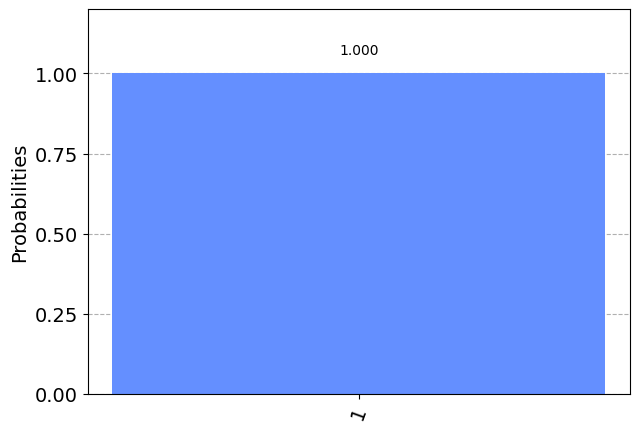

In [5]:
# running experiment on the Quasm simulator with 1024 shots

backend = Aer.get_backend('qasm_simulator')
qobj = assemble(circuit)

result_sim = backend.run(qobj, shots=1024).result()

# Zeige die Ergbenisse: Das Bit ganz links ist in der Qiskit-Notation das Ergebnis der Messung von q2!
counts = result_sim.get_counts(circuit)
print("print: 0 for constant, 1 for balanced")

print(counts)
plot_histogram(counts)

By using the Quasm simulator (theoretical only), we found a 100% cance in our oracle function being balanced.